# CarPricePredictor-MA — Notebook end-to-end
_Généré le 2025-11-03 15:07_

Ce notebook regroupe **toutes les étapes** :
1. Chargement et nettoyage des données
2. Analyse exploratoire (EDA) — **matplotlib uniquement**
3. Prétraitement (OneHotEncoder + StandardScaler)
4. Feature engineering
5. Modélisation (RandomForestRegressor)
6. Évaluation (RMSE, MAE, R²)
7. Sauvegarde du pipeline avec `joblib`
8. Démonstration d'inférence


## 1) Configuration & Imports

In [108]:
import os
import json
import math
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## 2) Chargement des données

In [109]:
df=pd.read_csv(r'C:\Users\saido\Desktop\CarPricePredictor-MA\data\DataSet.csv')
df.head()

,name,company,model,edition,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
0,Maruti Swift Dzire VDI,Maruti,Swift,Dzire VDI,2014,First,Diesel,Individual,Manual,145500,55.00,1248.0,74.00,190.000000,5.0,450000
1,Skoda Rapid 1.5 TDI Ambition,Skoda,Rapid,1.5 TDI Ambition,2014,Second,Diesel,Individual,Manual,120000,49.70,1498.0,103.52,250.000000,5.0,370000
2,Honda City 2017-2020 EXi,Honda,City,2017-2020 EXi,2006,Third,Petrol,Individual,Manual,140000,41.60,1497.0,78.00,124.544455,5.0,158000
3,Hyundai i20 Sportz Diesel,Hyundai,i20,Sportz Diesel,2010,First,Diesel,Individual,Manual,127000,54.06,1396.0,90.00,219.668960,5.0,225000
4,Maruti Swift VXI BSIII,Maruti,Swift,VXI BSIII,2007,First,Petrol,Individual,Manual,120000,37.84,1298.0,88.20,112.776475,5.0,130000


## 3) Nettoyage de donnes

In [110]:
# Vérifier les valeurs manquantes
df.isnull().sum()
# Supprimer les lignes avec des valeurs manquantes
df.dropna(inplace=True)
df.isnull().sum()

name             0
company          0
model            0
edition          0
year             0
owner            0
fuel             0
seller_type      0
transmission     0
km_driven        0
mileage_mpg      0
engine_cc        0
max_power_bhp    0
torque_nm        0
seats            0
selling_price    0
dtype: int64

In [111]:
#Supprimer les valeurs aberrantes (outliers)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
df.shape
df.head()

,name,company,model,edition,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
0,Maruti Swift Dzire VDI,Maruti,Swift,Dzire VDI,2014,First,Diesel,Individual,Manual,145500,55.00,1248.0,74.00,190.000000,5.0,450000
1,Skoda Rapid 1.5 TDI Ambition,Skoda,Rapid,1.5 TDI Ambition,2014,Second,Diesel,Individual,Manual,120000,49.70,1498.0,103.52,250.000000,5.0,370000
2,Honda City 2017-2020 EXi,Honda,City,2017-2020 EXi,2006,Third,Petrol,Individual,Manual,140000,41.60,1497.0,78.00,124.544455,5.0,158000
3,Hyundai i20 Sportz Diesel,Hyundai,i20,Sportz Diesel,2010,First,Diesel,Individual,Manual,127000,54.06,1396.0,90.00,219.668960,5.0,225000
4,Maruti Swift VXI BSIII,Maruti,Swift,VXI BSIII,2007,First,Petrol,Individual,Manual,120000,37.84,1298.0,88.20,112.776475,5.0,130000


In [112]:
#Compter le nombre total de doublons
nb_doublons = df.duplicated().sum()
print(f"Nombre de lignes dupliquées : {nb_doublons}")
#Éliminer les doublons
df.drop_duplicates(inplace=True)
df.shape
df.head()

Nombre de lignes dupliquées : 0


,name,company,model,edition,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
0,Maruti Swift Dzire VDI,Maruti,Swift,Dzire VDI,2014,First,Diesel,Individual,Manual,145500,55.00,1248.0,74.00,190.000000,5.0,450000
1,Skoda Rapid 1.5 TDI Ambition,Skoda,Rapid,1.5 TDI Ambition,2014,Second,Diesel,Individual,Manual,120000,49.70,1498.0,103.52,250.000000,5.0,370000
2,Honda City 2017-2020 EXi,Honda,City,2017-2020 EXi,2006,Third,Petrol,Individual,Manual,140000,41.60,1497.0,78.00,124.544455,5.0,158000
3,Hyundai i20 Sportz Diesel,Hyundai,i20,Sportz Diesel,2010,First,Diesel,Individual,Manual,127000,54.06,1396.0,90.00,219.668960,5.0,225000
4,Maruti Swift VXI BSIII,Maruti,Swift,VXI BSIII,2007,First,Petrol,Individual,Manual,120000,37.84,1298.0,88.20,112.776475,5.0,130000


In [113]:
# Afficher les types de données de chaque colonne
print('Types de données des colonnes :', df.dtypes)

Types de données des colonnes : name              object
company           object
model             object
edition           object
year               int64
owner             object
fuel              object
seller_type       object
transmission      object
km_driven          int64
mileage_mpg      float64
engine_cc        float64
max_power_bhp    float64
torque_nm        float64
seats            float64
selling_price      int64
dtype: object


In [114]:
## Séparer automatiquement les variables numériques et catégorielles
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print("Variables numériques :", numeric_features)
print("Variables catégorielles :", categorical_features)

Variables numériques : ['year', 'km_driven', 'mileage_mpg', 'engine_cc', 'max_power_bhp', 'torque_nm', 'seats', 'selling_price']
Variables catégorielles : ['name', 'company', 'model', 'edition', 'owner', 'fuel', 'seller_type', 'transmission']


In [115]:
# Définir le taux de conversion (de la roupie indienne ₹ vers le dirham marocain MAD)
INDIAN_RUPEE_TO_MAD = 0.13  # À ajuster selon le taux de change réel

# Conversion du prix de vente de la roupie vers le dirham marocain
df["selling_price_mad"] = df["selling_price"] * INDIAN_RUPEE_TO_MAD

# Vérification du résultat de la conversion (afficher les 5 premières lignes)
print(df[["selling_price", "selling_price_mad"]].head())
# Supprimer l'ancienne colonne de prix de vente en roupies
df = df.drop(columns=["selling_price"])
df = df.rename(columns={"selling_price_mad": "selling_price"})
df.head()


   selling_price  selling_price_mad
0         450000            58500.0
1         370000            48100.0
2         158000            20540.0
3         225000            29250.0
4         130000            16900.0


,name,company,model,edition,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
0,Maruti Swift Dzire VDI,Maruti,Swift,Dzire VDI,2014,First,Diesel,Individual,Manual,145500,55.00,1248.0,74.00,190.000000,5.0,58500.0
1,Skoda Rapid 1.5 TDI Ambition,Skoda,Rapid,1.5 TDI Ambition,2014,Second,Diesel,Individual,Manual,120000,49.70,1498.0,103.52,250.000000,5.0,48100.0
2,Honda City 2017-2020 EXi,Honda,City,2017-2020 EXi,2006,Third,Petrol,Individual,Manual,140000,41.60,1497.0,78.00,124.544455,5.0,20540.0
3,Hyundai i20 Sportz Diesel,Hyundai,i20,Sportz Diesel,2010,First,Diesel,Individual,Manual,127000,54.06,1396.0,90.00,219.668960,5.0,29250.0
4,Maruti Swift VXI BSIII,Maruti,Swift,VXI BSIII,2007,First,Petrol,Individual,Manual,120000,37.84,1298.0,88.20,112.776475,5.0,16900.0


## 4) EDA — Analyse exploratoire (matplotlib)

In [116]:
# afficher les statistiques descriptives des colonnes numériques
df.describe()

,year,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
count,4537.000000,4537.000000,4537.000000,4537.000000,4537.000000,4537.000000,4537.0,4537.000000
mean,2013.824333,65529.618030,49.087472,1215.331717,77.469580,141.519480,5.0,52316.153467
std,3.628317,38870.748052,7.405084,210.927856,15.884317,51.943003,0.0,27820.475033
min,2002.000000,1000.000000,28.200000,793.000000,35.000000,58.839900,5.0,4335.630000
25%,2011.000000,35000.000000,43.940000,1086.000000,67.100000,99.040000,5.0,29899.870000
50%,2014.000000,60000.000000,48.200000,1199.000000,75.000000,122.583125,5.0,46800.000000
75%,2017.000000,90000.000000,54.060000,1396.000000,88.500000,190.000000,5.0,71500.000000
max,2020.000000,194000.000000,66.750000,1896.000000,120.690000,300.000000,5.0,134550.000000


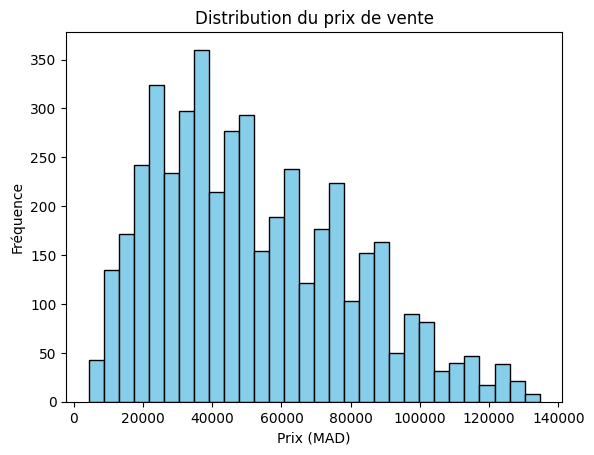

In [117]:
# On trace la distribution du prix de vente
plt.hist(df["selling_price"], bins=30, color="skyblue", edgecolor="black")

# Ajouter un titre au graphique
plt.title("Distribution du prix de vente")

# Nommer l’axe des X : le prix en dirhams marocains (MAD)
plt.xlabel("Prix (MAD)")

# Nommer l’axe des Y : la fréquence d’apparition
plt.ylabel("Fréquence")

# Afficher le graphique à l’écran
plt.show()

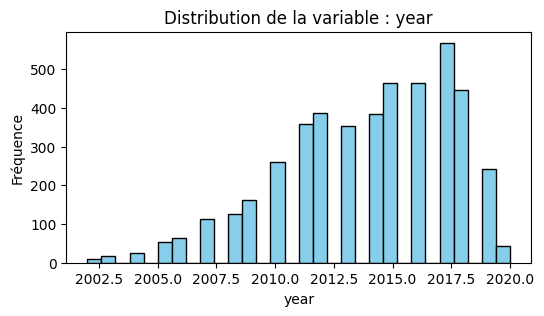

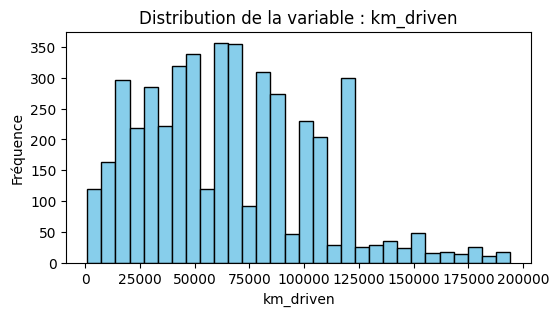

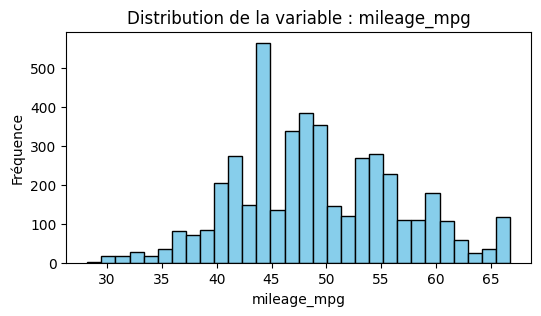

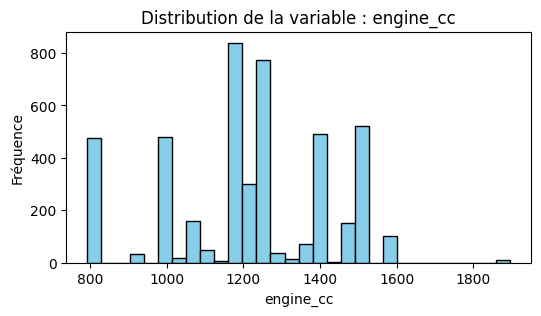

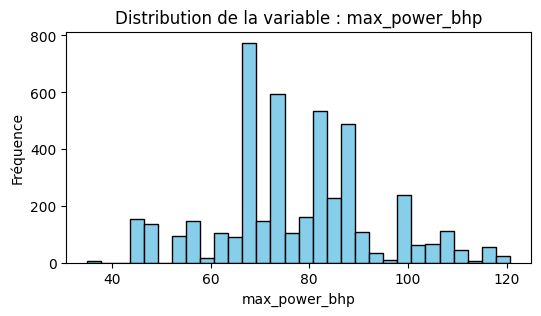

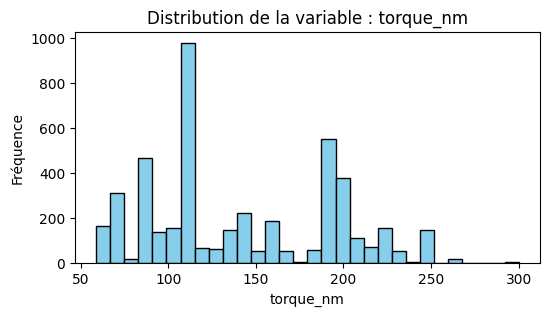

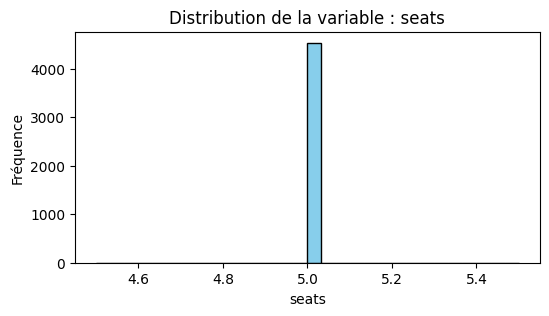

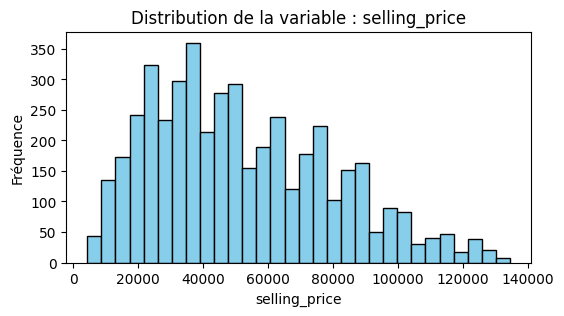

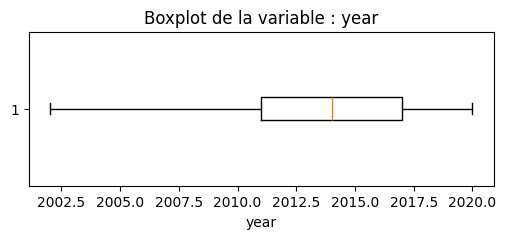

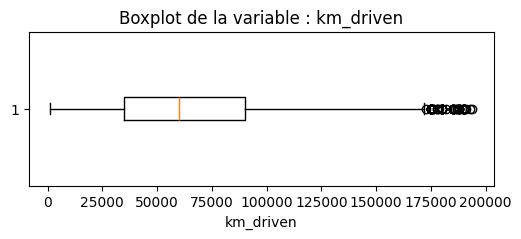

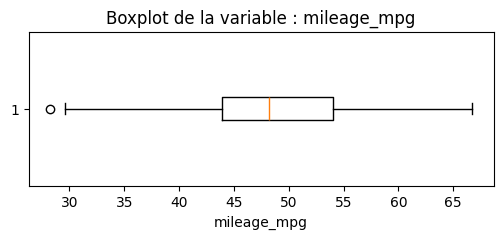

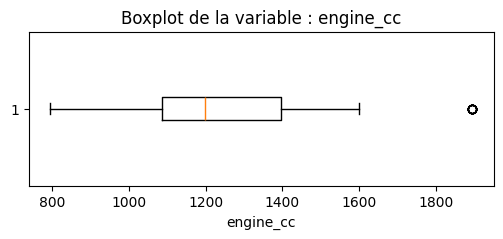

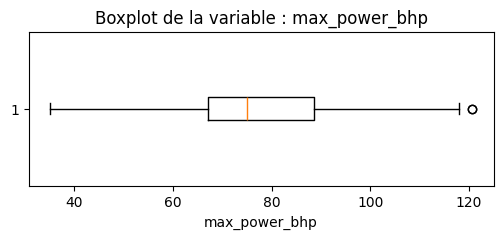

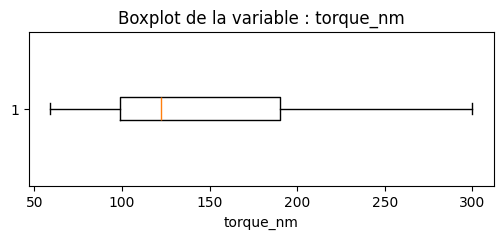

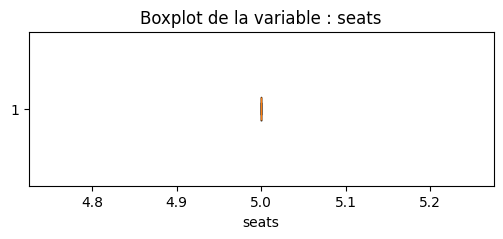

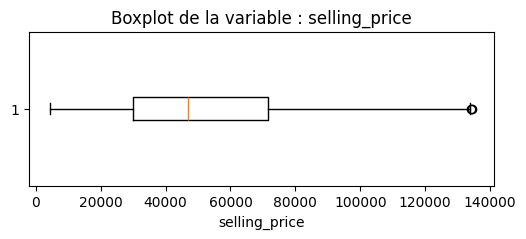

In [118]:
# Les histogrammes permettent d’observer la répartition des valeurs pour chaque variable numérique.
# Cela aide à repérer si les données sont concentrées, étalées ou contiennent des outliers.
colonnes_numeriques = df.select_dtypes(include=['int64', 'float64']).columns
for col in colonnes_numeriques:
    plt.figure(figsize=(6, 3))
    plt.hist(df[col].dropna(), bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Distribution de la variable : {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()
# Le boxplot montre la médiane, les quartiles et les valeurs aberrantes (points éloignés).
# C’est un bon outil pour détecter les outliers qui pourraient fausser l’entraînement du modèle.
for col in colonnes_numeriques:
    plt.figure(figsize=(6, 2))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Boxplot de la variable : {col}")
    plt.xlabel(col)
    plt.show()

 Matrice de corrélation :

                   year  km_driven  mileage_mpg  engine_cc  max_power_bhp  \
year           1.000000  -0.528619     0.462585  -0.016666       0.203120   
km_driven     -0.528619   1.000000    -0.109173   0.264455       0.009166   
mileage_mpg    0.462585  -0.109173     1.000000  -0.112075      -0.118836   
engine_cc     -0.016666   0.264455    -0.112075   1.000000       0.778158   
max_power_bhp  0.203120   0.009166    -0.118836   0.778158       1.000000   
torque_nm      0.133040   0.273100     0.320333   0.742459       0.640625   
seats               NaN        NaN          NaN        NaN            NaN   
selling_price  0.740278  -0.367411     0.379219   0.337661       0.536654   

               torque_nm  seats  selling_price  
year            0.133040    NaN       0.740278  
km_driven       0.273100    NaN      -0.367411  
mileage_mpg     0.320333    NaN       0.379219  
engine_cc       0.742459    NaN       0.337661  
max_power_bhp   0.640625    NaN   

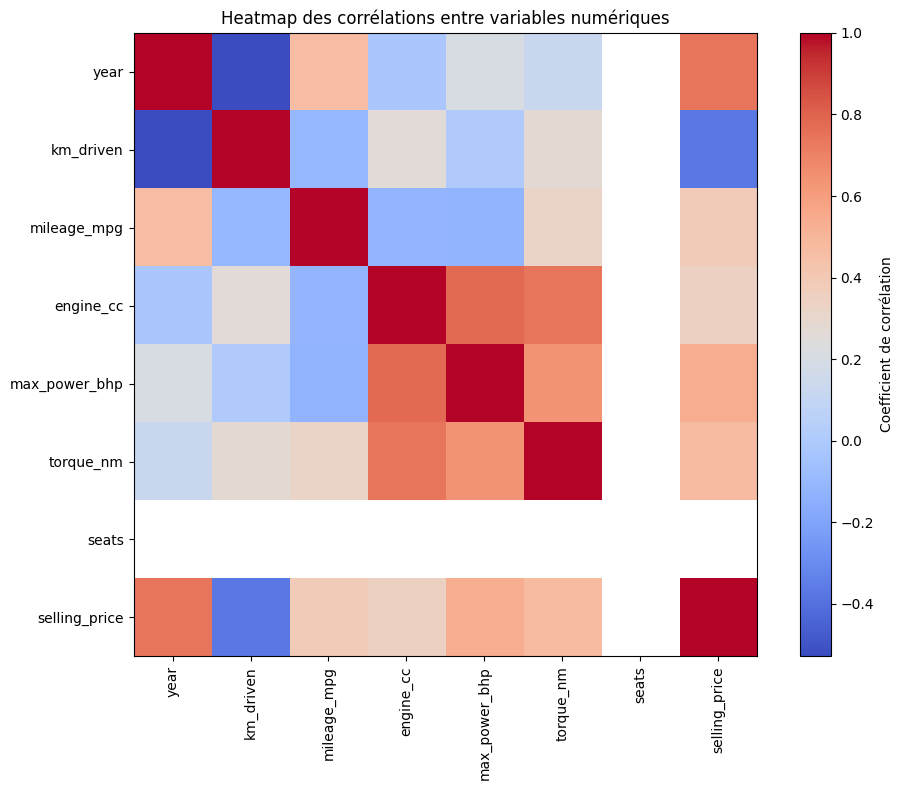

In [119]:
# Calculer la matrice de corrélation ---
# On sélectionne uniquement les colonnes numériques
colonnes_numeriques = df.select_dtypes(include=['int64', 'float64']).columns

# Matrice des corrélations
correlation_matrix = df[colonnes_numeriques].corr()

# --- Afficher la matrice sous forme de tableau numérique ---
print(" Matrice de corrélation :\n")
print(correlation_matrix)

# ---  Visualiser la heatmap avec matplotlib ---
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="nearest")

# Ajouter la barre de couleur à droite
plt.colorbar(label="Coefficient de corrélation")

# Ajouter les noms des colonnes sur les axes
plt.xticks(np.arange(len(colonnes_numeriques)), colonnes_numeriques, rotation=90)
plt.yticks(np.arange(len(colonnes_numeriques)), colonnes_numeriques)

plt.title("Heatmap des corrélations entre variables numériques")
plt.tight_layout()
plt.show()

In [120]:
print(df["seats"].value_counts())
print(df["seats"].isna().sum())
df = df.drop(columns=["seats"])
print("Colonne 'seats' supprimée car elle contient une seule valeur unique.")

seats
5.0    4537
Name: count, dtype: int64
0
Colonne 'seats' supprimée car elle contient une seule valeur unique.


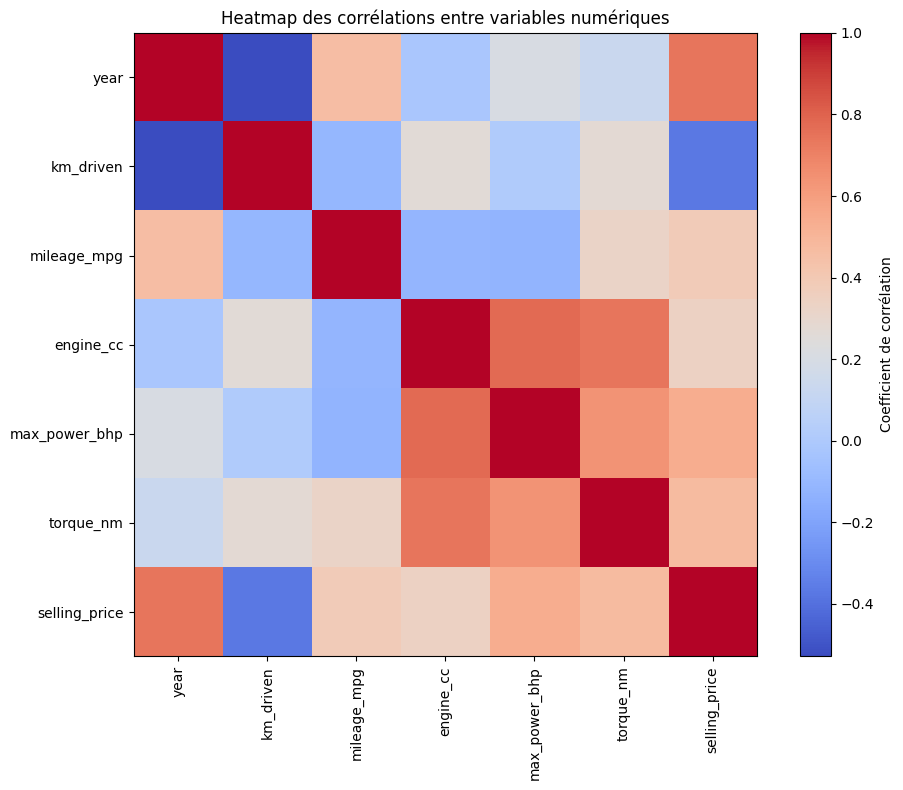

In [121]:
colonnes_numeriques = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[colonnes_numeriques].corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Coefficient de corrélation")
plt.xticks(np.arange(len(colonnes_numeriques)), colonnes_numeriques, rotation=90)
plt.yticks(np.arange(len(colonnes_numeriques)), colonnes_numeriques)
plt.title("Heatmap des corrélations entre variables numériques")
plt.tight_layout()
plt.show()

## 5) Prétraitement

In [122]:
# --- Séparer les colonnes numériques et catégorielles ---
colonnes_numeriques = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
colonnes_categorielles = df.select_dtypes(include=['object']).columns.tolist()
print("Colonnes numériques :", colonnes_numeriques)
print("Colonnes catégorielles :", colonnes_categorielles)

Colonnes numériques : ['year', 'km_driven', 'mileage_mpg', 'engine_cc', 'max_power_bhp', 'torque_nm', 'selling_price']
Colonnes catégorielles : ['name', 'company', 'model', 'edition', 'owner', 'fuel', 'seller_type', 'transmission']


Encodage des variables catégorielles (OneHotEncoder)

In [123]:
# Supprimer la colonne cible de la liste numérique (si présente)
if "selling_price" in colonnes_numeriques:
    colonnes_numeriques.remove("selling_price")

print("Variables numériques :", colonnes_numeriques)
print("Variables catégorielles :", colonnes_categorielles)

# ---  Créer le préprocesseur ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), colonnes_numeriques),            # Normalisation des données numériques
        ("cat", OneHotEncoder(handle_unknown="ignore"), colonnes_categorielles)  # Encodage des variables catégorielles
    ]
)

# --- Tester la transformation ---
X = df.drop(columns=["selling_price"])
y = df["selling_price"]

# Appliquer l'encodage sur X
X_transformed = preprocessor.fit_transform(X)

print("✅ Encodage terminé !")
print("Taille avant :", X.shape)
print("Taille après :", X_transformed.shape)

Variables numériques : ['year', 'km_driven', 'mileage_mpg', 'engine_cc', 'max_power_bhp', 'torque_nm']
Variables catégorielles : ['name', 'company', 'model', 'edition', 'owner', 'fuel', 'seller_type', 'transmission']
✅ Encodage terminé !
Taille avant : (4537, 14)
Taille après : (4537, 2409)


Standardisation des variables numériques

In [124]:
# ---  Sélectionner uniquement les colonnes numériques à standardiser ---
colonnes_numeriques = ["year", "km_driven", "mileage_mpg", "engine_cc", "max_power_bhp", "torque_nm"]

# ---  Créer un objet StandardScaler ---
scaler = StandardScaler()

# ---  Appliquer la standardisation sur les colonnes numériques ---
df[colonnes_numeriques] = scaler.fit_transform(df[colonnes_numeriques])

# ---  Vérification ---
print("Standardisation terminée avec succès ")
display(df[colonnes_numeriques].head())

Standardisation terminée avec succès 


,year,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm
0,0.048421,2.057568,0.798530,0.154896,-0.218452,0.933444
1,0.048421,1.401475,0.082726,1.340266,1.640190,2.088683
2,-2.156701,1.916058,-1.011237,1.335525,0.033396,-0.326837
3,-1.054140,1.581579,0.671576,0.856635,0.788942,1.504690
4,-1.881061,1.401475,-1.519052,0.391970,0.675610,-0.553418


Création de nouvelles features

In [125]:
# --- Créer une colonne "vehicle_age" : âge du véhicule ---
current_year = datetime.now().year
df["vehicle_age"] = current_year - df["year"]

# ---  Créer une colonne "power_per_km" : puissance par kilomètre parcouru ---
df["power_per_km"] = df["max_power_bhp"] / df["km_driven"]
df["power_per_km"] = df["power_per_km"].replace([np.inf, -np.inf], np.nan).fillna(0)

# ---  Créer une colonne "price_per_cc" : prix par cylindrée ---
df["price_per_cc"] = df["selling_price"] / df["engine_cc"]
df["price_per_cc"] = df["price_per_cc"].replace([np.inf, -np.inf], np.nan).fillna(0)

# ---  Créer une colonne "mileage_per_year" : kilométrage par année d’utilisation ---
df["mileage_per_year"] = df["km_driven"] / df["vehicle_age"]
df["mileage_per_year"] = df["mileage_per_year"].replace([np.inf, -np.inf], np.nan).fillna(0)

# --- Vérification ---
print("Nouvelles features créées avec succès ")
display(df[["vehicle_age", "power_per_km", "price_per_cc", "mileage_per_year"]].head())

Nouvelles features créées avec succès 


,vehicle_age,power_per_km,price_per_cc,mileage_per_year
0,2024.951579,-0.106170,377672.730370,0.001016
1,2024.951579,1.170331,35888.397509,0.000692
2,2027.156701,0.017430,15379.724785,0.000945
3,2026.054140,0.498832,34145.228576,0.000781
4,2026.881061,0.482071,43115.542821,0.000691


## 6) Modélisation

Entraîner un RandomForestRegressor

In [126]:
# --- 1) Séparer X / y ---
# y en numérique au cas où (si le prix était string après conversion de devise, إلخ)
y = pd.to_numeric(df["selling_price"], errors="coerce")
X = df.drop(columns=["selling_price"])

# --- 2) Lister colonnes numériques et catégorielles ---
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# (Option recommandé) Retirer 'name' s'il contient trop de catégories/texte long:
# if "name" in cat_cols:
#     X = X.drop(columns=["name"])
#     cat_cols.remove("name")

print(" Numériques :", num_cols)
print(" Catégorielles :", cat_cols)

# --- 3) Préprocesseur: scaler pour numériques + one-hot pour catégorielles ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

# --- 4) Modèle dans un Pipeline complet ---
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=200,     # + grand => + précis (mais + lent)
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# --- 5) Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# --- 6) Entraînement ---
model.fit(X_train, y_train)
print(" Entraînement du RandomForest terminé !")

# --- 7) Évaluation ---
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(" Résultats de l'évaluation :")
print(f"  • RMSE : {rmse:.2f}")
print(f"  • MAE  : {mae:.2f}")
print(f"  • R²   : {r2:.3f}")

 Numériques : ['year', 'km_driven', 'mileage_mpg', 'engine_cc', 'max_power_bhp', 'torque_nm', 'vehicle_age', 'power_per_km', 'price_per_cc', 'mileage_per_year']
 Catégorielles : ['name', 'company', 'model', 'edition', 'owner', 'fuel', 'seller_type', 'transmission']
 Entraînement du RandomForest terminé !
 Résultats de l'évaluation :
  • RMSE : 3382.47
  • MAE  : 1713.89
  • R²   : 0.985


Sauvegarder le pipeline complet avec joblib

In [128]:
Path("ml/artifacts").mkdir(parents=True, exist_ok=True)

# ---  Chemin du fichier modèle ---
model_path = "../ml/artifacts/model.joblib"

# ---  Sauvegarder le pipeline complet (préprocessing + modèle RandomForest) ---
joblib.dump(model, model_path)

print(f" Pipeline complet sauvegardé avec succès dans : {model_path}")


 Pipeline complet sauvegardé avec succès dans : ../ml/artifacts/model.joblib
